# <FONT COLOR='red'>**_OVERALL DESCRIPTION_**</FONT>

---
---

The purpose of this notebook is realize the fine-tunning to the Google's BERT model to obtain a new model named **CIEF-BERT** that can correctly classify the elephant and mice flows of the DCN traffic traces using a modified UNI1 data set, called UNIV1.


## <FONT COLOR = 'gray'>**INSTALL AND IMPORT**</FONT>

---

Next, we need install some libraries.

1. `pip install accelerate -U`: Library developed by Hugging Face that helps involve setting up and running deep learning models on different hardware (CPU, GPU, TPU). Improves efficiency and ease of use when fine-tuning large models like BERT, especially when working in environments with multiple GPUs or specialized hardware.
2. `!pip install torch`:Core library for PyTorch. It provides all the essential functionalities for building and training deep learning models, including defining neural network architectures, optimization algorithms, and tensor management.
3. `!pip install transformers[torch]`: Library developed by Hugging Face that contains a wide collection of pre-trained transformer models, including BERT, GPT, T5, among others. Allows you to load, configure and use transformer models with ease. It includes functionalities to perform fine-tuning of pre-trained models on specific NLP tasks. The [torch] indicates that the PyTorch-compatible version is being installed.

In [ ]:
%%capture
!pip install accelerate -U
!pip install torch
!pip install transformers[torch]

Google Colab offers free GPUs and TUPS since we'll be training a large neural network it's best to take advantage of this, otherwise training will take a very long time.

In [ ]:
# IMPORT TENSORFLOW
import tensorflow as tf

# GPU IDENTIFICATION
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  # PRESENT AN ERROR IF DON'T SELECTED THE FREE GPU
  raise SystemError('GPU device not found.')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


it's necesary that we identify and specify the GPU as the device to that torch use the GPU.

In [ ]:
# IMPORT TORCH
import torch

# SELECT DEVICE
if torch.cuda.is_available():
  device = torch.device('cuda')
  n_gpu = torch.cuda.device_count()
  torch.cuda.get_device_name(0)
else:
  device = torch.device('cpu')
print(f'It is in use: {device}')

It is in use: cuda


The next section is related to loading and cleaning the UNIV1 data set to be used. Therefore, it is necessary to import some libraries to work with UNIV1.

1. `import pandas as pd`: Library for manipulation and analysis of structured data. It facilitates the loading, manipulation and analysis of the input data that will be used for model training.
2. `import numpy as np`: Library for manipulating multidimensional arrays and matrices. It provides support for efficient mathematical and logical operations, crucial for data processing and calculations necessary in model training.

In [ ]:
# IMPORT LIBRARIES TO MANIPULATE THE DATA
import pandas as pd
import numpy as np

## <FONT COLOR = 'orange'>**LOAD DATASET**</FONT>

---

We will use the UNIV1 dataset which is a modification of the UNI1 dataset, which contains traffic traces from several DCNs collected by a university in 2010. The traffic traces in the dataset are only IPv4.

UNIV1 contain the follow structure:

1. `start_time`: Represent the beginning of the capture per flow.
2. `end_time`: Represent the finish of the capture per flow.
3. `ip_src`: Represent the source IPv4.
4. `ip_dst`: Represent the destination IPv4.
5. `ip_proto`: Represent the IP protocol used.
6. `port_src`: Represent the source port.
7. `port_dst`: Represent the destination port.
8. `size_pkt1`: Represent the size of the packet 1.
9. `size_pkt2`: Represent the size of the packet 2.
10. `size_pkt3`: Represent the size of the packet 3.
11. `size_pkt4`: Represent the size of the packet 4.
12. `size_pkt5`: Represent the size of the packet 5.
13. `size_pkt6`: Represent the size of the packet 6.
14. `size_pkt7`: Represent the size of the packet 7.
15. `iat_pkt2`: Represent the inter arrive time of the packet 2.
16. `iat_pkt3`: Represent the inter arrive time of the packet 3.
17. `iat_pkt4`: Represent the inter arrive time of the packet 4.
18. `iat_pkt5`: Represent the inter arrive time of the packet 5.
19. `iat_pkt6`: Represent the inter arrive time of the packet 6.
20. `iat_pkt7`: Represent the inter arrive time of the packet 7.
21. `tot_size`: Represent the total size per flow.
22. `flow_type`: Represent the flow type as elephant or mice.

It was identified that keeping IP addresses in dot notation and the IP address as a number (IP with dot notation: 41.177.26.55. IP as a number: 411772655) does not generate a great impact on the classification process, so it was decided to treat them as numbers for ease.

In [ ]:
# UN1 ID DATASET
id = '1Nt4A7U0P_2x7VYfX0T7Tr21tt3CHIREl'

# GENERATE THE DOWNLOAD URL
url_univ1 = f'https://drive.google.com/uc?id={id}'

# DOWNLOAD AND LOAD UNI1 DATASET IN A DATAFRAME OF PANDAS
univ1_df = pd.read_csv(url_univ1)
univ1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73256 entries, 0 to 73255
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   start_time  73256 non-null  int64 
 1   end_time    73256 non-null  int64 
 2   ip_src      73256 non-null  int64 
 3   ip_dst      73256 non-null  int64 
 4   ip_proto    73256 non-null  int64 
 5   port_src    73256 non-null  int64 
 6   port_dst    73256 non-null  int64 
 7   size_pkt1   73256 non-null  int64 
 8   size_pkt2   73256 non-null  int64 
 9   size_pkt3   73256 non-null  int64 
 10  size_pkt4   73256 non-null  int64 
 11  size_pkt5   73256 non-null  int64 
 12  size_pkt6   73256 non-null  int64 
 13  size_pkt7   73256 non-null  int64 
 14  iat_pkt2    73256 non-null  int64 
 15  iat_pkt3    73256 non-null  int64 
 16  iat_pkt4    73256 non-null  int64 
 17  iat_pkt5    73256 non-null  int64 
 18  iat_pkt6    73256 non-null  int64 
 19  iat_pkt7    73256 non-null  int64 
 20  tot_si

In [ ]:
# PRESENT AND SAMPLE OF THE UNI1 DATASET
pd.set_option('display.max_columns', None)
display(univ1_df.sample(10))

,start_time,end_time,ip_src,ip_dst,ip_proto,port_src,port_dst,size_pkt1,size_pkt2,size_pkt3,size_pkt4,size_pkt5,size_pkt6,size_pkt7,iat_pkt2,iat_pkt3,iat_pkt4,iat_pkt5,iat_pkt6,iat_pkt7,tot_size,flow_type
498,1261067279289197,1261067280260709,411772615,24443108186,6,80,15244,78,70,380,1438,1438,1438,1438,125958,6114,18279,22,126742,21,116882,mice
10707,1261069201781167,1261069203632145,41177230128,411779831,6,25,48221,70,154,64,277,64,113,64,55843,718,341,599,6848,107641,38535,mice
30548,1261070218493426,1261070218700055,2443160239,2443241204,6,80,14760,66,64,1518,647,1518,647,358,18920,82704,20,1239,24,3941,24540,mice
58899,1261068634444576,1261068635001911,4117726176,7719712818,6,80,49331,66,64,1518,1028,1518,1518,769,81660,311717,5,129,81735,5,12063,mice
36437,1261070793743644,1261070795282595,4117726176,77197128127,6,80,49102,66,64,1518,1518,336,1059,1518,81748,1211302,9,7,58,81921,21870,elephant
61905,1261070708020529,1261070708650563,4117726176,77197128155,6,80,47352,66,64,1518,1028,1518,1518,770,81798,384592,5,139,81652,5,11633,elephant
68360,1261067950083309,1261067951313101,4117726176,15186110142,6,80,34442,82,70,1491,728,298,155,298,69837,1007652,12484,270,25,236,11147,mice
24652,1261069221325057,1261069223911130,4117726176,6722210119,6,80,34830,82,70,1518,455,830,425,161,279111,1732928,5,8442,181,29,12777,mice
7900,1261068733771725,1261068734512463,4117798220,2443177117,6,7020,2317,1438,1102,288,290,285,286,281,4,2284,1804,1790,1789,1757,16796,mice
8073,1261068756367106,1261068759505083,2443160248,4117726209,17,48916,514,157,163,169,185,160,259,253,4540,40738,20149,1137,287382,14945,10942,mice


In [ ]:
# REPLACE ELEPHANT BY 1 AND MICE BY 0 TO AVOID HALLUCINATION PROBLEMS.
univ1_df = univ1_df.replace({'elephant':1, 'mice':0})
print(f'Unique values of flow_type: {univ1_df["flow_type"].unique()}')

Unique values of flow_type: [0 1]


To fine-tune correctly the BERT model to obtain the CIEF-BERT model is necesary create the sentences with their respective tokens for that the BERT model understand. Moreover is necesary obtain the labels, in this case if the flow is classify as a Elephant or mice flow.

In [ ]:
# TEMPLATE THAT CREATE THE SENTENCES TO USE THE MODEL
def sentences_creation(data):
  return ' '.join([f"{feature}:{data[feature]}" for feature in data.index])

In [ ]:
# SPLIT DATASET IN FEATURES AND LABELS
features_df = univ1_df.drop(labels='flow_type', axis=1)
labels_df = univ1_df.flow_type
print('\nINFORMATION OF THE FEATURES:')
display(features_df.info())
print('\nINFORMATION OF THE LABELS:')
display(labels_df.info())


INFORMATION OF THE FEATURES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73256 entries, 0 to 73255
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   start_time  73256 non-null  int64
 1   end_time    73256 non-null  int64
 2   ip_src      73256 non-null  int64
 3   ip_dst      73256 non-null  int64
 4   ip_proto    73256 non-null  int64
 5   port_src    73256 non-null  int64
 6   port_dst    73256 non-null  int64
 7   size_pkt1   73256 non-null  int64
 8   size_pkt2   73256 non-null  int64
 9   size_pkt3   73256 non-null  int64
 10  size_pkt4   73256 non-null  int64
 11  size_pkt5   73256 non-null  int64
 12  size_pkt6   73256 non-null  int64
 13  size_pkt7   73256 non-null  int64
 14  iat_pkt2    73256 non-null  int64
 15  iat_pkt3    73256 non-null  int64
 16  iat_pkt4    73256 non-null  int64
 17  iat_pkt5    73256 non-null  int64
 18  iat_pkt6    73256 non-null  int64
 19  iat_pkt7    73256 non-null  int64
 20

None


INFORMATION OF THE LABELS:
<class 'pandas.core.series.Series'>
RangeIndex: 73256 entries, 0 to 73255
Series name: flow_type
Non-Null Count  Dtype
--------------  -----
73256 non-null  int64
dtypes: int64(1)
memory usage: 572.4 KB


None

In [ ]:
# CREATE THE SENTENCES
sentences = features_df.apply(sentences_creation, axis=1)

# INSERT TOKENS TO THE SENTENCES
sentences = [f'[CLS] {sentence} [SEP]' for sentence in sentences]

In [ ]:
# TRANSFORM INTO PANDAS DATAFRAME AND INSERT THE LABELS
sentences_df = pd.DataFrame({'sentence':sentences})
sentences_df['label'] = labels_df
sentences_df.sample(10)

,sentence,label
39194,[CLS] start_time:1261069073701046 end_time:126...,0
60806,[CLS] start_time:1261068023615578 end_time:126...,1
17509,[CLS] start_time:1261070548784921 end_time:126...,0
16044,[CLS] start_time:1261070226318026 end_time:126...,0
34186,[CLS] start_time:1261068840239594 end_time:126...,0
73123,[CLS] start_time:1261069534568318 end_time:126...,0
599,[CLS] start_time:1261067299003519 end_time:126...,0
20121,[CLS] start_time:1261070863078775 end_time:126...,1
60890,[CLS] start_time:1261070949142438 end_time:126...,1
26763,[CLS] start_time:1261067851254783 end_time:126...,1


## <FONT COLOR = 'orange'>**LLM FINE-TUNNING**</FONT>

---

Now, we use the BERT tokenizer to convert our text into tokens that correspond to BERT's vocabulary. To realize this, we need import some libraries.

1. `from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback`: These tools allow you to load, configure and train the BERT model for specific tasks such as text classification. Trainer and TrainingArguments simplify the training process, while EarlyStoppingCallback helps prevent overfitting by stopping training at the right time. It is important to note that BertTokenizer is responsible for bringing the tokenizer of the BERT model and BertForSequenceClassification brings an adaptation of the BERT model for sequence classification.
2. `from sklearn.model_selection import train_test_split, StratifiedKFold`: train_test_split allows you to efficiently split the data to train and test the model fairly, while StratifiedKFold ensures that each fold in the cross-validation has a similar class distribution as the original data set.
3. `from tqdm import tqdm, trange`: It provides visual feedback on the progress of the training and evaluation loops, improving the process monitoring experience, as well as within the loading processes necessary to obtain the model parts.

### <FONT COLOR = 'gray'>**PREPARING DATA**</FONT>

In [ ]:
# IMPORT LIBRARIES TO REALIZE THE PREPARING DATA
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, AdamW, EarlyStoppingCallback
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm, trange

In [ ]:
# LOAD THE BERT TOKENIZER
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# DATA SPLIT IN base_data AND eval_data
seed = 42
base_data, eval_data = train_test_split(sentences_df, test_size=0.1, stratify=sentences_df['label'], random_state=seed)
# BASE DATA SPLIT IN train_data AND test_data
train_data, test_data = train_test_split(base_data, test_size=0.3, stratify=base_data['label'], random_state=seed)

# CHECK THE CLASS DISTRIBUTION BETWEEN base_data AND eval_data
print(
  f'''\n\nClass distribution between base_data and eval_data.
  \nBase set class distribution: {base_data["label"].value_counts(normalize=True)}.
  \nEvaluation set class distribution: {eval_data["label"].value_counts(normalize=True)}.'''
)

# CHECK THE CLASS DISTRIBUTION BETWEEN train_data AND test_data
print(
  f'''\n\nClass distribution between base_data and eval_data.
  \nBase set class distribution: {train_data["label"].value_counts(normalize=True)}.
  \nEvaluation set class distribution: {test_data["label"].value_counts(normalize=True)}.'''
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]



Class distribution between base_data and eval_data.
  
Base set class distribution: label
0    0.648855
1    0.351145
Name: proportion, dtype: float64.
  
Evaluation set class distribution: label
0    0.648785
1    0.351215
Name: proportion, dtype: float64.


Class distribution between base_data and eval_data.
  
Base set class distribution: label
0    0.648848
1    0.351152
Name: proportion, dtype: float64.
  
Evaluation set class distribution: label
0    0.64887
1    0.35113
Name: proportion, dtype: float64.


In [ ]:
# Tokenizer text
def tokenize_text(data):
  input = data['sentence'].tolist()
  labels = data['label'].tolist()
  return tokenizer(input, truncation=True, padding='max_length', max_length=400), torch.tensor(labels)

# DATA TRAIN
train_input, train_labels = tokenize_text(train_data)

# DATA TEST
test_input, test_labels = tokenize_text(test_data)

# DATA EVALUATION
eval_input, eval_labels = tokenize_text(eval_data)

In [ ]:
# CREATE THE PYTORCH'S DATASET
class Network_flow_dataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # Now using the correct attribute name
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

In [ ]:
train_dataset = Network_flow_dataset(train_input, train_labels)
test_dataset = Network_flow_dataset(test_input, test_labels)
eval_dataset = Network_flow_dataset(eval_input, eval_labels)

### <FONT COLOR = 'gray'>**TRAIN MODEL**</FONT>
---
---
Now it is time to instantiate the pre-trained BERT model. It is important specify `num_labels=2` because we want to classify the flows in elephant and mice only.

In [ ]:
#  DEFINE THE PRE-TRAINED ARCHITECTURE MODEL TO USE
bert_model_flow_classification = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


It is time to configure the function in charge of calculating each of the metrics with which the performance of the fine-tuning carried out on BERT will be evaluated to obtain what will be called CIEF-BERT.

In [ ]:
# IMPORT METRICS LIBRARY
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
# IMPORT FIGURE LIBRARY
import matplotlib.pyplot as plt
import seaborn as sns

# CONSTRUCT THE FIGURE TO THE CONFUSION MATRIX
def create_cm(conf, title):
  plt.imshow(conf, interpolation = "nearest")
  class_names = [0,1]
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # Create a heatmap in to the confusion matrix
  sns.heatmap(pd.DataFrame(conf), annot=True, cmap=plt.cm.Blues, fmt='g')
  plt.tight_layout()
  plt.title(title)
  plt.xlabel('Predict')
  plt.ylabel('Real')

  plt.tight_layout()
  plt.show()
  plt.close()

# DEFINE A CUSTOM compute_metrics FUNCTION
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  accu = accuracy_score(labels, predictions)
  pres = precision_score(labels, predictions)
  f1_s = f1_score(labels, predictions)
  conf = confusion_matrix(labels, predictions)
  # PRINT THE CONFISION
  create_cm(conf,'Confusion Matrix')
  # RETURN METRICS
  return {
      'accuracy': accu,
      'precision': pres,
      'f1_score': f1_s
  }

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-15-4ed51f74da58>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Step,Training Loss,Validation Loss,Accuracy,Precision,F1 Score
400,0.624800,0.516190,0.760251,0.741822,0.587652
800,0.501100,0.417807,0.821073,0.716998,0.760765
1200,0.422200,0.392955,0.820365,0.677592,0.784601
1600,0.379300,0.367269,0.837403,0.711466,0.795965
2000,0.369700,0.335487,0.847869,0.718959,0.811147
2400,0.281300,0.231995,0.906921,0.801085,0.880617
2800,0.175600,0.152791,0.950149,0.884501,0.932898
3200,0.138900,0.150543,0.949037,0.879749,0.931717
3600,0.109500,0.110351,0.966884,0.922829,0.954460
4000,0.102100,0.097802,0.971384,0.934478,0.960381


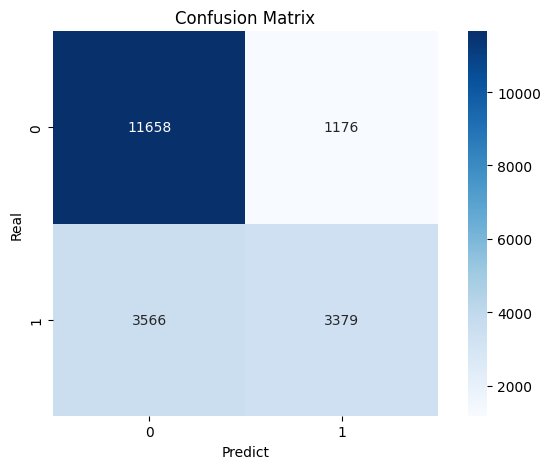

<ipython-input-15-4ed51f74da58>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


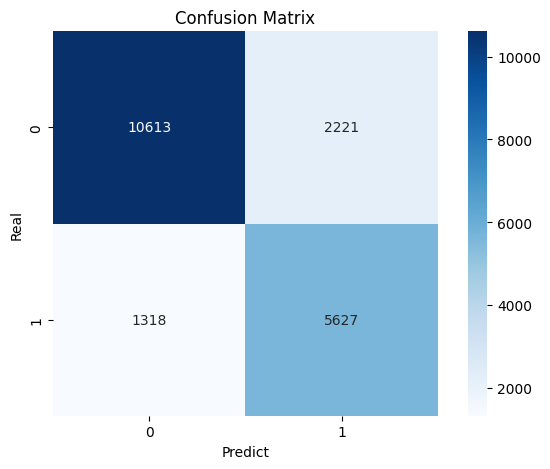

<ipython-input-15-4ed51f74da58>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


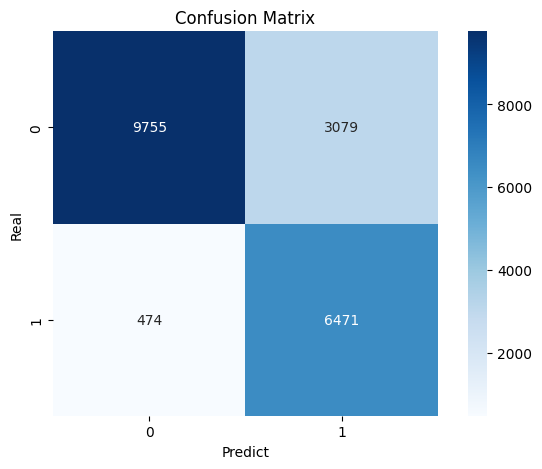

<ipython-input-15-4ed51f74da58>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


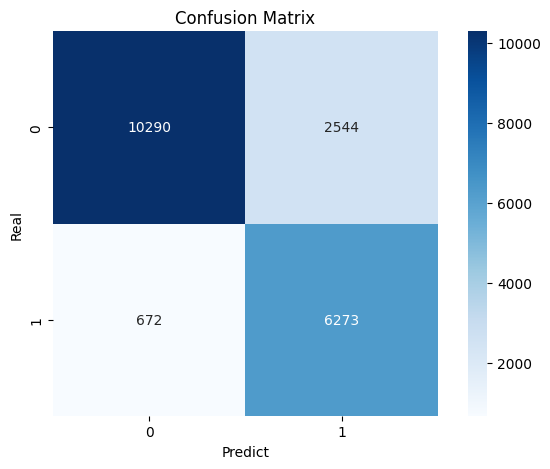

<ipython-input-15-4ed51f74da58>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


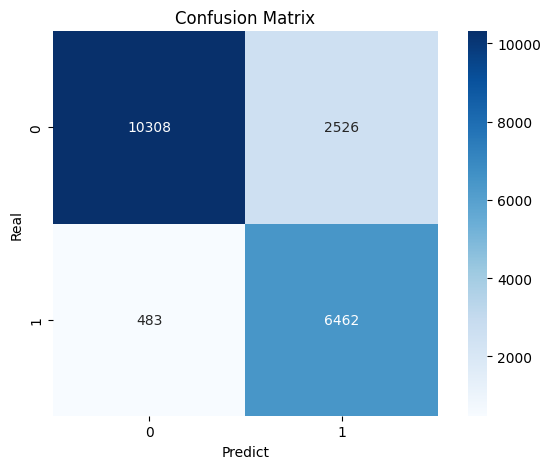

<ipython-input-15-4ed51f74da58>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


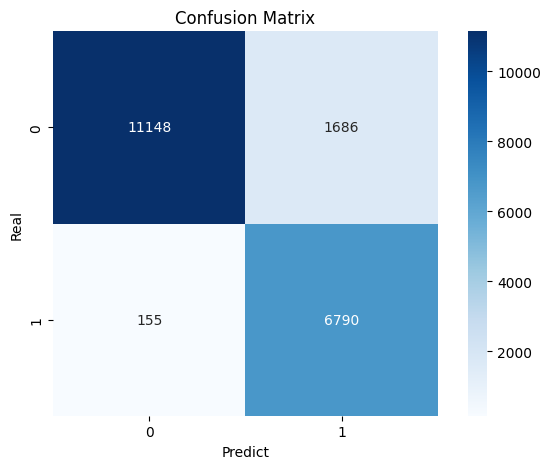

<ipython-input-15-4ed51f74da58>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


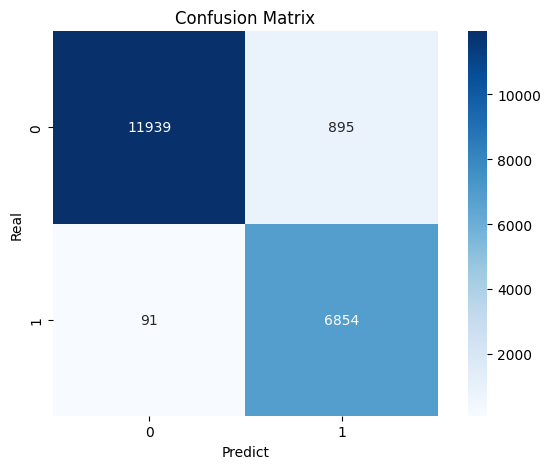

<ipython-input-15-4ed51f74da58>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


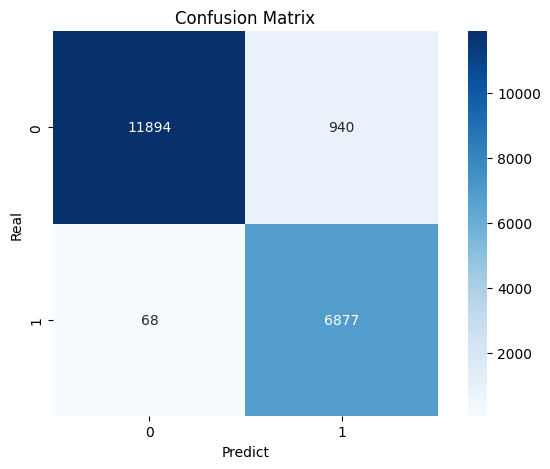

<ipython-input-15-4ed51f74da58>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


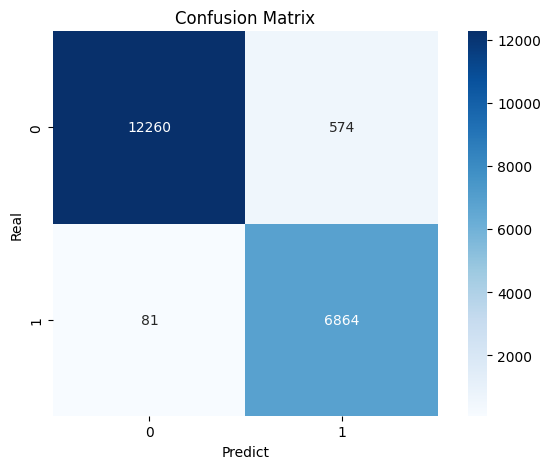

<ipython-input-15-4ed51f74da58>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


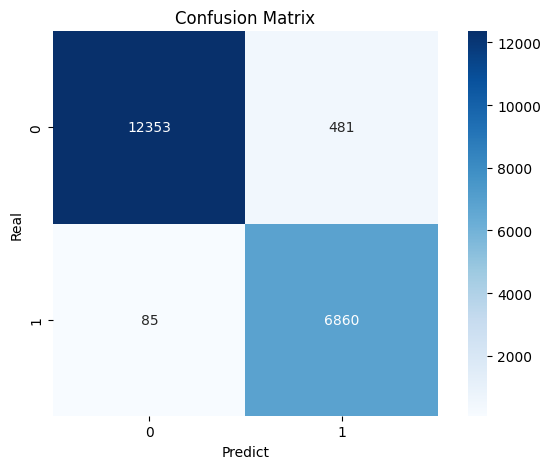

<ipython-input-15-4ed51f74da58>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


TrainOutput(global_step=4329, training_loss=0.29437786427456225, metrics={'train_runtime': 3965.3868, 'train_samples_per_second': 34.915, 'train_steps_per_second': 1.092, 'total_flos': 2.8459777302936e+16, 'train_loss': 0.29437786427456225, 'epoch': 3.0})

In [ ]:
# Define training arguments for flow_type classification
training_args_flow_type = TrainingArguments(
    output_dir='./bert-hh-elephant',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=400,
    save_steps=400,
    save_total_limit=3,
    num_train_epochs=3,
    learning_rate=1e-6,
    logging_dir='./logs-flow-type',
    load_best_model_at_end=True,
    logging_steps=400,
    eval_accumulation_steps=1,
    fp16=True,
)

# Create a Trainer for fine-tuning the flow_type BERT model
trainer_flow_classification = Trainer(
    model=bert_model_flow_classification,
    args=training_args_flow_type,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=None,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0001)],  # Adjusted early stopping
    optimizers=(AdamW(bert_model_flow_classification.parameters(), lr=1e-6, weight_decay=0.01), None)
)

# Define a custom loss function
def custom_loss(predictions, labels):
    loss_fn = torch.nn.CrossEntropyLoss()
    return loss_fn(predictions.logits, labels)

# Override the model's forward pass to calculate the custom loss
def compute_loss(model, inputs, return_outputs=False):
    outputs = model(**inputs)
    logits = outputs.logits
    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(logits.view(-1, model.config.num_labels), inputs['labels'].view(-1))
    return (loss, outputs) if return_outputs else loss

# Set the Trainer's compute_loss to the modified function
trainer_flow_classification.compute_loss = compute_loss

# Start the training process
trainer_flow_classification.train()

It is time to save the model after training to be able to evaluate it without depending on the maximum time of the free Google Colab resources.

In [ ]:
import zipfile
import os
from google.colab import files

# Save the fine-tuned model and tokenizer for inference
bert_model_path = './bert-ids-finetuned'

# Guardar el modelo
bert_model_flow_classification.save_pretrained(bert_model_path)

# Guardar el tokenizer
tokenizer.save_pretrained(bert_model_path)

# Nombre del archivo zip de salida
zip_file_name = 'bert-ids-finetuned.zip'

# Función para crear el archivo zip
def zip_dir(dir_path, zip_path):
   with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
       for root, _, files in os.walk(dir_path):
           for file in files:
               zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), dir_path))

# Crear el archivo zip
zip_dir(bert_model_path, zip_file_name)

# Descargar el archivo zip
files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-15-4ed51f74da58>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Step,Training Loss,Validation Loss,Accuracy,Precision,F1 Score
24,No log,0.079939,0.979473,0.959264,0.971132


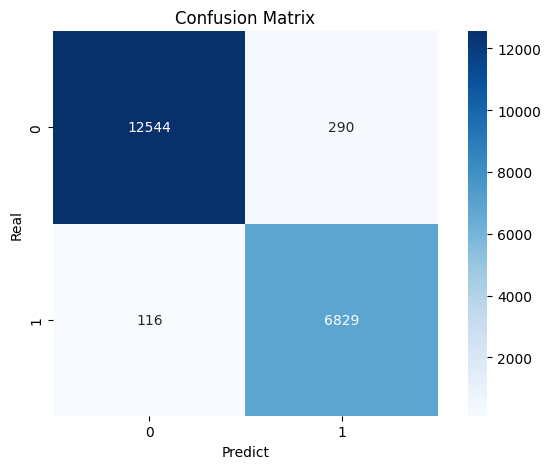

In [ ]:
# Evaluate the model
results = trainer_flow_classification.evaluate()

In [ ]:
results

{'eval_loss': 0.0799388512969017,
 'eval_accuracy': 0.9794731786237929,
 'eval_precision': 0.9592639415648265,
 'eval_f1_score': 0.9711319681456201}